In [14]:
def fbeta(y_true, y_pred, beta = 0.5):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    #
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    #
    fbeta = (1 + beta**2) *p*r / (beta**2 *p+r+K.epsilon())
    fbeta = tf.where(tf.math.is_nan(fbeta), tf.zeros_like(fbeta), fbeta)
    return K.mean(fbeta)

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind_from_stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=10

import tensorflow as tf
import tensorflow.keras
tensorflow.keras.losses.custom_loss = fbeta
tensorflow.keras.metrics.fbeta = fbeta

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow.keras.metrics
tf.config.experimental.list_physical_devices('GPU')
import copy

In [22]:
model = load_model("/projects/pfenninggroup/machineLearningForComputationalBiology/addiction_gwas_enrichment/lcl_variant_prediction/lcl_human/CNN/GM12878_DNase_CNN1_Fhalf_cvw6_lr0.01.h5", compile=False)

In [23]:
tewhey_ref_1kb = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_ref_sequences.npy")
tewhey_alt_1kb = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_alt_sequences.npy")


In [24]:
seqLen = int(tewhey_ref_1kb.shape[1])
newSeqLen = int(167)

In [25]:
tewhey_ref_167bp = tewhey_ref_1kb[:,(int(seqLen/2)-int(newSeqLen/2))-1:(int(seqLen/2)+int(newSeqLen/2)),:]
tewhey_alt_167bp = tewhey_alt_1kb[:,(int(seqLen/2)-int(newSeqLen/2))-1:(int(seqLen/2)+int(newSeqLen/2)),:]

In [26]:
g_channel_ref = copy.deepcopy(tewhey_ref_167bp[:,:,1])
c_channel_ref = copy.deepcopy(tewhey_ref_167bp[:,:,2])

g_channel_alt = copy.deepcopy(tewhey_alt_167bp[:,:,1])
c_channel_alt = copy.deepcopy(tewhey_alt_167bp[:,:,2])

In [27]:
tewhey_ref_167bp[:,:,1] = c_channel_ref
tewhey_ref_167bp[:,:,2] = g_channel_ref

tewhey_alt_167bp[:,:,1] = c_channel_alt
tewhey_alt_167bp[:,:,2] = g_channel_alt

In [28]:
tewhey_ref_167bp = np.expand_dims(tewhey_ref_167bp, axis=3)
tewhey_alt_167bp = np.expand_dims(tewhey_alt_167bp, axis=3)

In [29]:
tewhey_ref_pred = model.predict(tewhey_ref_167bp)
tewhey_alt_pred = model.predict(tewhey_alt_167bp)

In [30]:
tewhey_snp_info = pd.read_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_snps_data_extended_joined_to_1kg_mappings_with_1kb_snp_centered_sequences_with_gm_overlaps.txt",
                              sep="\t")

In [ ]:
tewhey_snp_info["Ref.score"] = tewhey_ref_pred
tewhey_snp_info["Alt.score"] = tewhey_alt_pred
tewhey_snp_info["Predicted.skew"] = np.log2(tewhey_snp_info["Alt.score"]) - np.log2(tewhey_snp_info["Ref.score"])

In [ ]:
plt.scatter(tewhey_snp_info["C.B.log2FC"], tewhey_snp_info["Alt.score"], c='k', s=5)
plt.scatter(tewhey_snp_info["C.A.log2FC"], tewhey_snp_info["Ref.score"], c='k', s=5)
plt.xlabel("Tewhey et al\nlog(rna/dna)")
plt.ylabel("Predicted Regulatory Activity")
print("Reference Sequences:",pearsonr(np.nan_to_num(tewhey_snp_info["C.A.log2FC"]), tewhey_snp_info["Ref.score"]))
print("Reference Sequences:",spearmanr(np.nan_to_num(tewhey_snp_info["C.A.log2FC"]), tewhey_snp_info["Ref.score"]))
print("Alternate Sequences:",pearsonr(np.nan_to_num(tewhey_snp_info["C.B.log2FC"]), tewhey_snp_info["Alt.score"]))
print("Alternate Sequences:",spearmanr(np.nan_to_num(tewhey_snp_info["C.B.log2FC"]), tewhey_snp_info["Alt.score"]))

In [4]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"],tewhey_snp_info["Predicted.skew"] , c = 'k', s=5)
plt.axhline(y=0, c='r', linestyle='--')
plt.axvline(x=0, c='r', linestyle='--')
plt.xlabel("Tewhey et al. Allelic Skew\nlog2(alt/ref)")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

NameError: name 'tewhey_snp_info' is not defined

(0.047163336432418324, 7.034973679418437e-21)
SpearmanrResult(correlation=0.046588122967794555, pvalue=2.06777825225048e-20)


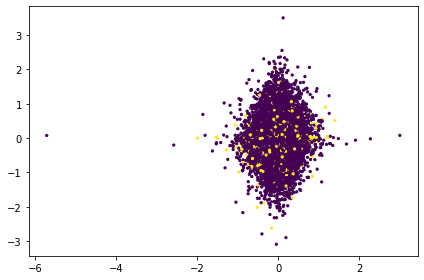

In [96]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"], tewhey_snp_info["Predicted.skew"], c = tewhey_snp_info["Num.Overlaps.GM.peaks"]>0, s=5)
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

In [97]:
tewhey_snp_info_sig = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_sig = tewhey_snp_info_sig[np.absolute(tewhey_snp_info_sig["LogSkew.Comb"])>0.5]
print(sum(np.sign(tewhey_snp_info_sig["LogSkew.Comb"]) == np.sign(np.log2(tewhey_snp_info_sig["Alt.score"]) - np.log2(tewhey_snp_info_sig["Ref.score"]))))
print(sum(np.sign(tewhey_snp_info_sig["LogSkew.Comb"]) != np.sign(np.log2(tewhey_snp_info_sig["Alt.score"]) - np.log2(tewhey_snp_info_sig["Ref.score"]))))

240
151


(0.22527101719017678, 6.85531401782066e-06)
SpearmanrResult(correlation=0.22513058735199773, pvalue=6.948705687985199e-06)


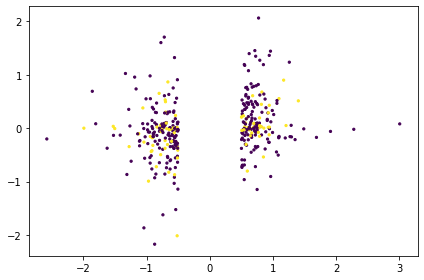

In [98]:
plt.scatter(tewhey_snp_info_sig["LogSkew.Comb"], tewhey_snp_info_sig["Predicted.skew"], c= tewhey_snp_info_sig["Num.Overlaps.GM.peaks"]>0, s=5)
print(pearsonr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))

In [99]:
tewhey_snp_info_pos = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.5]

Ttest_1sampResult(statistic=-3.387583166872122, pvalue=0.0008467977835299476)
Ttest_1sampResult(statistic=0.43668732336281507, pvalue=0.6623671243945901)
Ttest_1sampResult(statistic=3.9636807313116083, pvalue=0.00010513502687022808)
Ttest_indResult(statistic=-3.4148132794986252, pvalue=0.0007598128332462443)
Ttest_indResult(statistic=3.8059039138642397, pvalue=0.0001872875927124924)


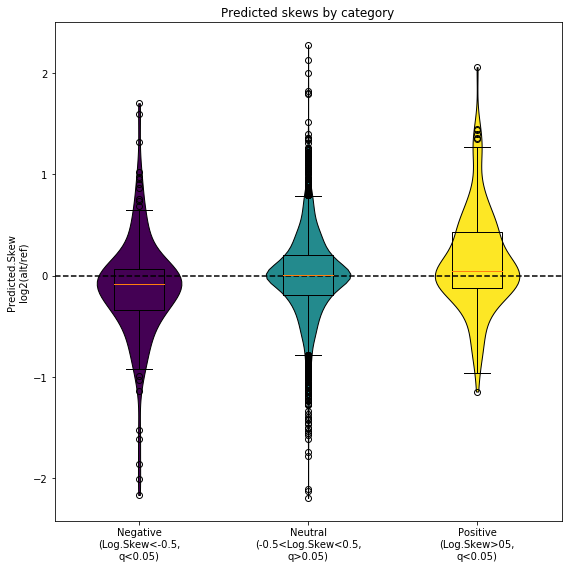

In [103]:
fig, ax = plt.subplots(figsize=(8,8))

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.5<Log.Skew<0.5,\nq>0.05)", "Positive\n(Log.Skew>05,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category")
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))

In [104]:
tewhey_snp_info_overlapping_peaks = tewhey_snp_info[tewhey_snp_info["Num.Overlaps.GM.peaks"]>0]
tewhey_snp_info_pos = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.5]

Ttest_1sampResult(statistic=-2.6349179338622726, pvalue=0.011063272727505409)
Ttest_1sampResult(statistic=0.0013175018555114078, pvalue=0.9989491907731908)
Ttest_1sampResult(statistic=1.8625195591269987, pvalue=0.07048490577162993)
Ttest_indResult(statistic=-2.6231832668640975, pvalue=0.011249679940582118)
Ttest_indResult(statistic=1.851012860250218, pvalue=0.071565156072465)


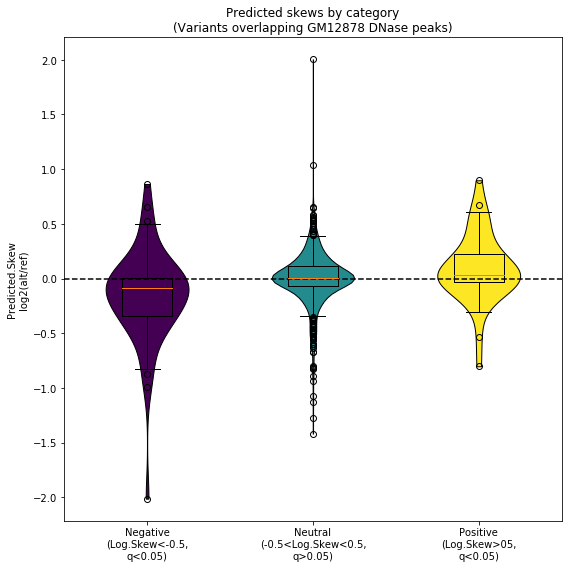

In [105]:
fig, ax = plt.subplots(figsize=(8,8))

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.5<Log.Skew<0.5,\nq>0.05)", "Positive\n(Log.Skew>05,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category\n(Variants overlapping GM12878 DNase peaks)")
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))